In [1]:
# Example of taking the output of our tally form to bootstrap a model card
import sys
import json
from IPython import display
import pandas as pd
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, precision_score, recall_score

# parent directory to work with dev
sys.path.append("..")
import model_card_toolkit as mctlib
from model_card_toolkit import model_card_pb2, ModelCard
from model_card_toolkit.utils.tally_form import tally_form_to_mc
from model_tests.utils import plot_to_str
from model_tests.FEAT.SubgroupDisparity import SubgroupDisparity
from model_tests.FEAT.SubgroupMetricThreshold import SubgroupMetricThreshold
from model_tests.FEAT.Permutation import Permutation
from model_tests.FEAT.SHAPFeatureImportance import SHAPFeatureImportance
from model_tests.FEAT.FeatureImportance import FeatureImportance
from model_tests.FEAT.DataShift import DataShift

## Prepare sample test dataset and fit a random forest model

In [2]:
# Credit card fraud Dataset
df = pd.read_csv("../data/fraud.csv")
x = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# # Credit risk dataset
# df = pd.read_csv("../data/credit_reject.csv")
# x = df.drop("reject", axis=1)
# y = df["reject"]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.7, random_state=32
)
estimator = RandomForestClassifier(n_estimators=10, max_features="sqrt", random_state = 32)

# Apply one hot encoding to categorical columns (auto-detect object columns)
ens = ce.OneHotEncoder(use_cat_names=True)
x_train = ens.fit_transform(x_train)
x_test = ens.transform(x_test)

# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy()
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]

precision_train = round(precision_score(y_train, estimator.predict(x_train)),3)
recall_train = round(recall_score(y_train, estimator.predict(x_train)), 3)
precision_test = round(precision_score(y_test, y_pred),3)
recall_test = round(recall_score(y_test, y_pred), 3)

output = ens.inverse_transform(output)
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas

# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test.columns, "value": estimator.feature_importances_}
)

# Get back dataframe with categorical features not encoded
train = ens.inverse_transform(x_train)
test = ens.inverse_transform(x_test)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## Get confusion matrix and ROC curve on train/test set

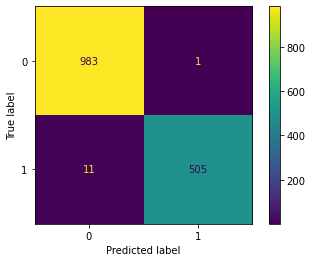

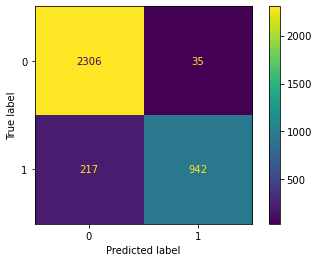

In [3]:
# Train set
plot_confusion_matrix(estimator, x_train, y_train)
confusion_matrix_train = plot_to_str()

# Test set
plot_confusion_matrix(estimator, x_test, y_test)
confusion_matrix_test = plot_to_str()

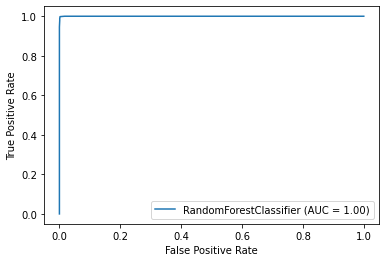

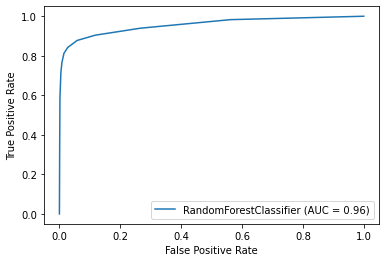

In [4]:
# Train set
plot_roc_curve(estimator, x_train, y_train)
roc_curve_train = plot_to_str()

# Test set
plot_roc_curve(estimator, x_test, y_test)
roc_curve_test = plot_to_str()

## Run some FEAT Tests on the data

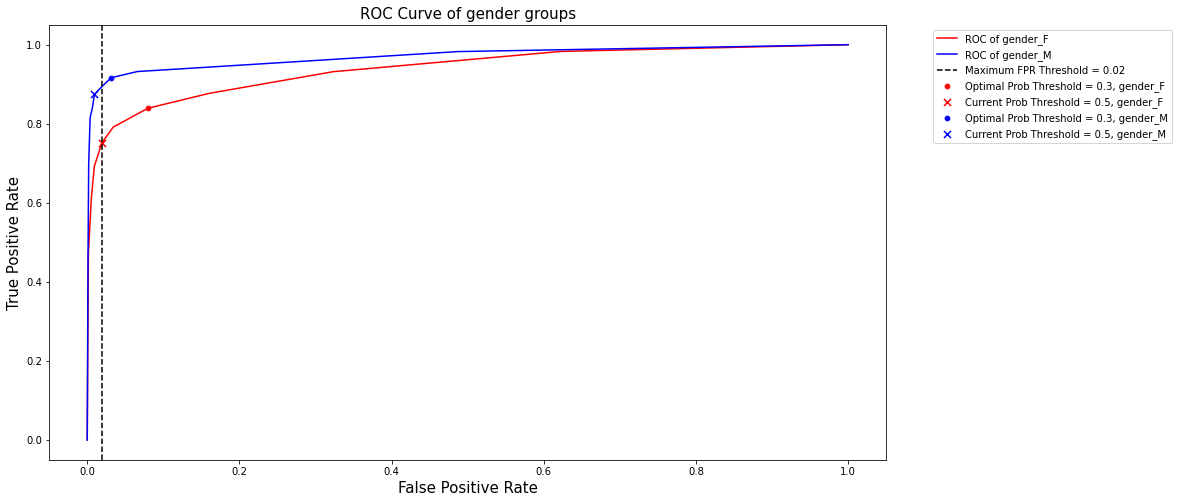

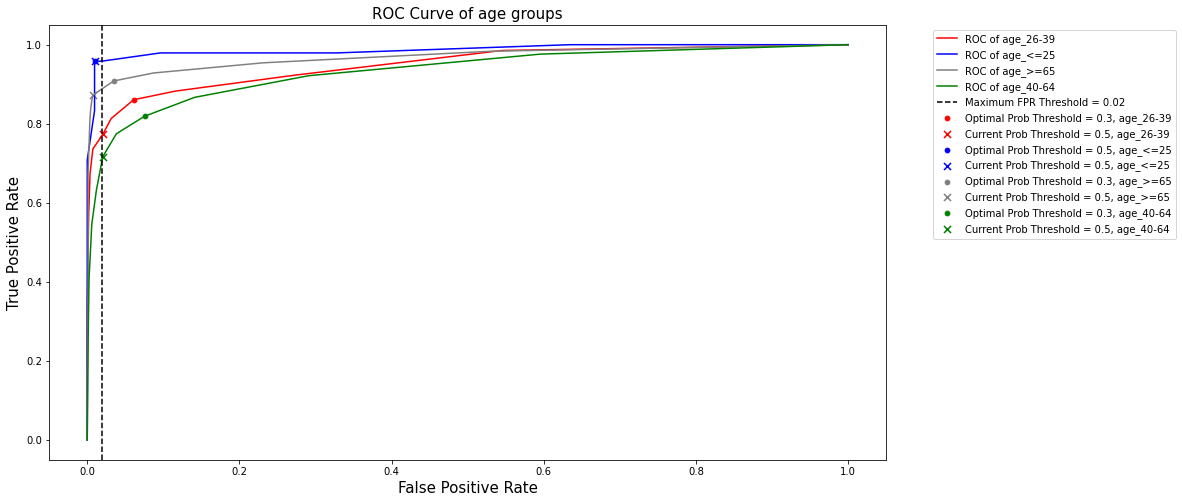

In [5]:
# Subgroup ROC/Threshold Test

smt_test = SubgroupMetricThreshold(
    #test_name="",
    #test_desc="",
    attr="gender",
    metric="fpr",
    threshold=0.02,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test.run(df_test_with_output=output)
smt_test.plot()

smt_test2 = SubgroupMetricThreshold(
    #test_name="",
    #test_desc="",
    attr="age",
    metric="fpr",
    threshold=0.02,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test2.run(df_test_with_output=output)
smt_test2.plot()

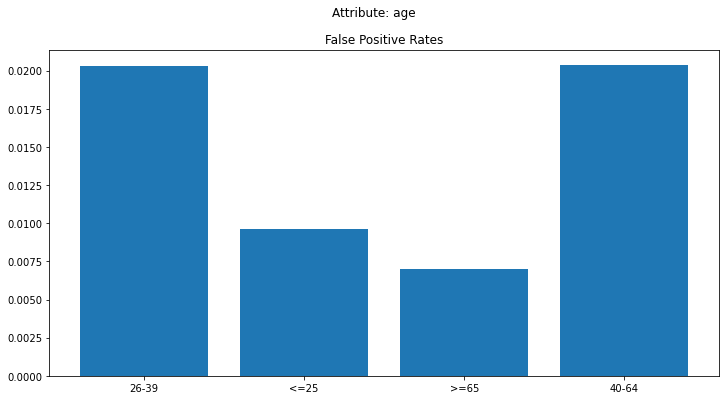

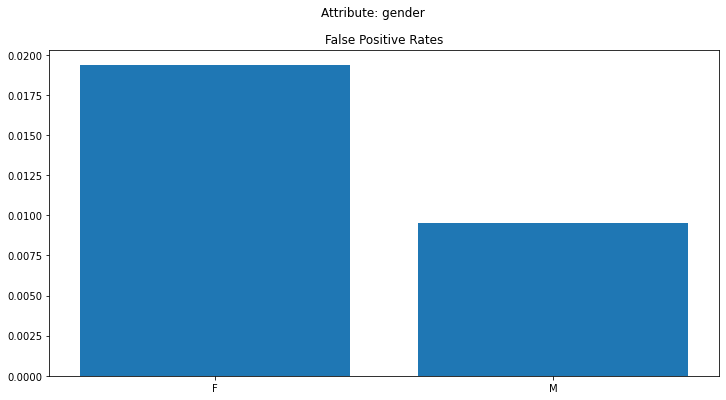

In [6]:
# Subgroup Disparity Test
sgd_test = SubgroupDisparity(
    #test_name="",
    #test_desc="",
    attr='age',
    metric='fpr',
    method='ratio',
    threshold=1.25,
)
sgd_test.run(output)
sgd_test.plot()

sgd_test2 = SubgroupDisparity(
    #test_name="",
    #test_desc="",
    attr='gender',
    metric='fpr',
    method='ratio',
    threshold=1.25,
)
sgd_test2.run(output)
sgd_test2.plot()

In [7]:
# Subgroup Permutation Test
pmt = Permutation(
    #test_name='permutation',
    #test_desc='',
    attr='age',
    metric='pr',
    method='ratio',
    threshold=1.5,
)

pmt.run(
    x_test=x_test,
    y_test=y_test,
    encoder=ens,
    model=estimator
)

True

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


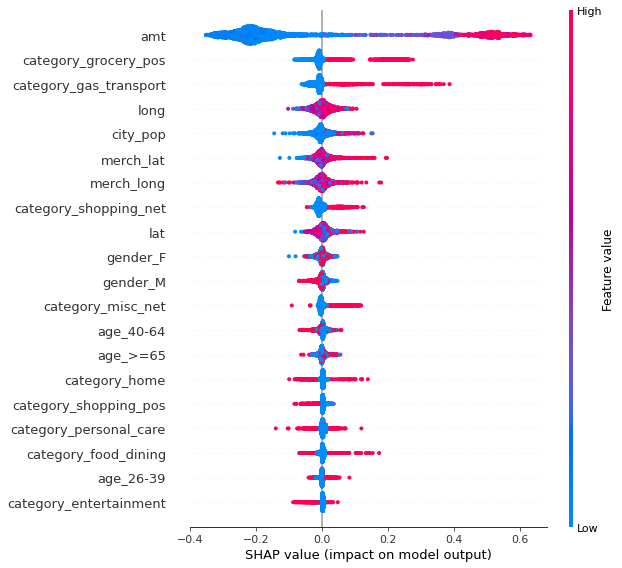

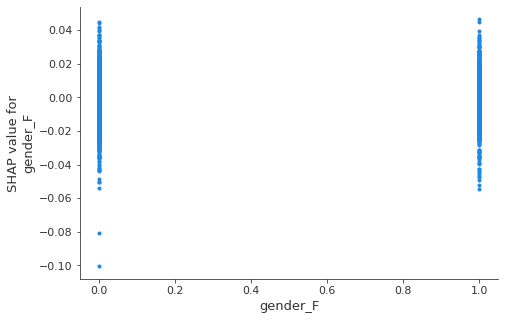

In [8]:
# Shapely Importance Features Test
shap_test = SHAPFeatureImportance(
    #test_name="",
    #test_desc="",
    attrs=['gender','age'],
    threshold=10
)

shap_test.run(
    model=estimator,
    model_type='trees',
    x_train=x_train,
    x_test=x_test,
)
shap_test.shap_summary_plot(x_test)
shap_test.shap_dependence_plot(x_test, show_all=False) # Show only dependence plots of attributes that failed the test

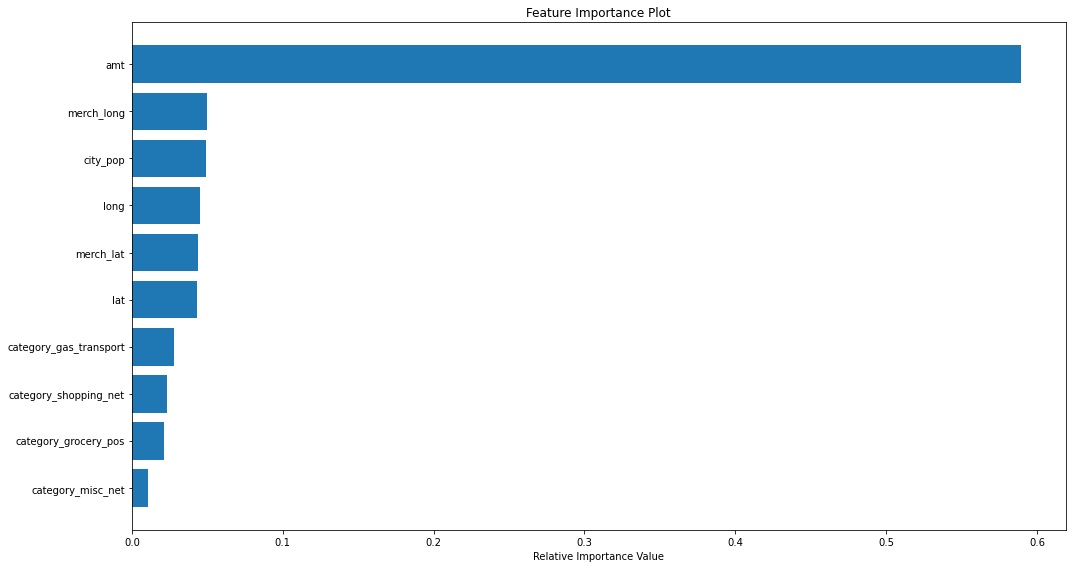

In [9]:
# User inputted Feature importance test
imp_test = FeatureImportance(
    #test_name="",
    #test_desc="",
    attrs=['gender','age'],
    threshold=10
)

imp_test.run(df_importance)
imp_test.plot(df_importance,show_n=10)

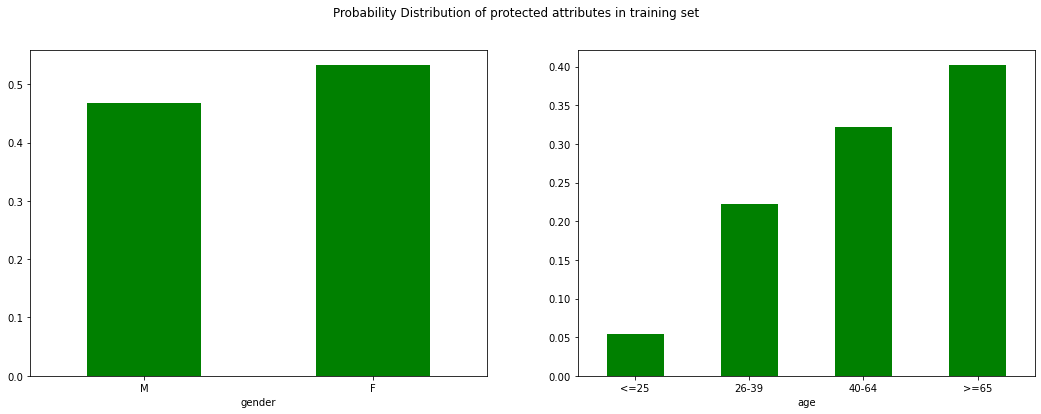

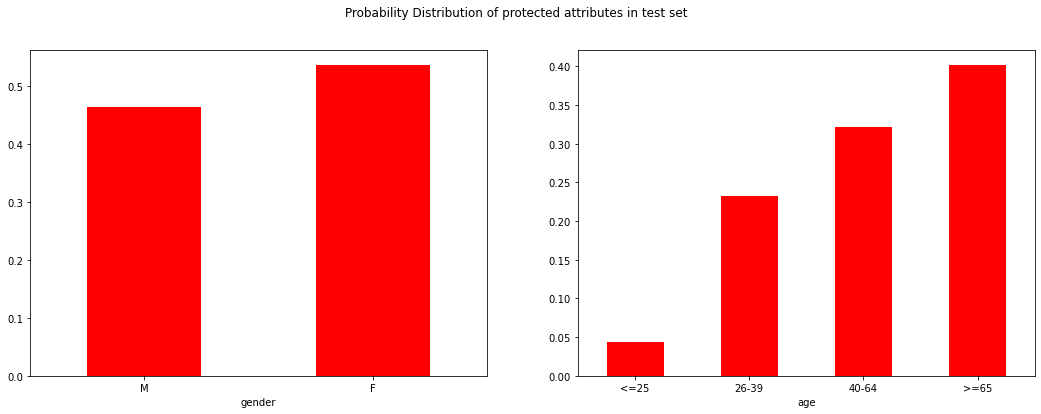

In [10]:
# Data distribution Shift Test
shift_test = DataShift(
    #test_name="",
    #test_desc="",
    protected_attr = ['gender','age'],
    method = 'ratio',
    threshold = 1.25
)

shift_test.run(df_train = train, df_eval = test)
shift_test.plot(train, test)

## Bootstrap model card from tally form and scaffold assets
We can add the quantitative analysis, explainability analysis and fairness analysis sections to a bootstrap model card for convenience. In this example, we use an existing model card which we created from the tally form response. This is meant only as an example - the dataset and risk evaluation in the model card is a fictional use case.

In [11]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response.json")

# Initialize the mct and scaffold using the existing protobuf
mct = mctlib.ModelCardToolkit(output_dir = "model_card_output", file_name="credit_card_fraud_example")
mc = mct.scaffold_assets(proto=pb)

## Convert test objects to a model-card-compatible format

In [12]:
# init model card test objects
mc_smt_test = mctlib.Test()
mc_smt_test2 = mctlib.Test()
mc_sgd_test = mctlib.Test()
mc_sgd_test2 = mctlib.Test()
mc_pmt_test = mctlib.Test()
mc_shap_test = mctlib.Test()
mc_imp_test = mctlib.Test()
mc_shift_test = mctlib.Test()

# assign tests to them
mc_smt_test.read_model_test(smt_test)
mc_smt_test2.read_model_test(smt_test2)
mc_sgd_test.read_model_test(sgd_test)
mc_sgd_test2.read_model_test(sgd_test2)
mc_pmt_test.read_model_test(pmt)
mc_imp_test.read_model_test(imp_test)
mc_shap_test.read_model_test(shap_test)
mc_shift_test.read_model_test(shift_test)

In [13]:
# Add quantitative analysis

### TODO: improve the display of train / test - you should not need to assign the metric to type. It should be assigned to "value" field.
mc.quantitative_analysis.performance_metrics[0].type = f"Recall - {recall_train}, Precision - {precision_train}"
mc.quantitative_analysis.performance_metrics[0].slice = "Training Set"
mc.quantitative_analysis.performance_metrics[0].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[0].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_train), mctlib.Graphic(image=roc_curve_train)
]

mc.quantitative_analysis.performance_metrics[1].type = f"Recall - {recall_test}, Precision - {precision_test}"
mc.quantitative_analysis.performance_metrics[1].slice = "Test Set"
mc.quantitative_analysis.performance_metrics[1].graphics.description = (
  'Confusion matrix and ROC Curve')
mc.quantitative_analysis.performance_metrics[1].graphics.collection = [
    mctlib.Graphic(image=confusion_matrix_test), mctlib.Graphic(image=roc_curve_test)
]

In [14]:
# You can add the components of a test (e.g. on explainability) in a report
mc.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(
        type="Top 10 most important features", graphics=mctlib.GraphicsCollection(
            collection = [mctlib.Graphic(name=n, image=i) for n, i in imp_test.plots.items()]
        )
    )
]

# Or you can add it as a test directly
mc.explainability_analysis.explainability_reports.append(
    mctlib.ExplainabilityReport(type="Protected Attributes should not be model's top important features", tests=[mc_shap_test])
)

In [15]:
# The bootstrap template comes with two requirements on fairness analysis:
# Minimum acceptable service and Equal false positive rate
# We add the relevant tests associated with it
mc.fairness_analysis.fairness_reports[0].tests = [mc_smt_test,mc_smt_test2]
mc.fairness_analysis.fairness_reports[1].tests = [mc_sgd_test,mc_sgd_test2]

# We also add a test for attribute shift between the training and testing dataset for additional reliablity check
mc.fairness_analysis.fairness_reports.append(
    mctlib.FairnessReport(type="Distribution of subgroups should be silimiar across different datasets", tests=[mc_shift_test])
)

mct.update_model_card(mc)

In [16]:
# Export to html
html = mct.export_format(output_file="credit_card_fraud_example.html")

display.display(display.HTML(html))

,feature_rank,passed
gender_F,10.0,False
gender_M,11.0,True
age_40-64,13.0,True
age_>=65,14.0,True
age_26-39,19.0,True
age_<=25,26.0,True
,fpr at current probability threshold,passed
gender_F,0.019,True
gender_M,0.01,True
